## Import modules

Make sure that Python 3 and the following modules (recommended version ID) are installed on your computer:

In [1]:
# to install with pip run:
# pip install -r requirements.txt

with open('requirements.txt', 'r') as f:
    print(''.join(f.readlines()))

jupyter==1.0.0
pyFirmata==1.1.0
numpy==1.18.4
opencv-python==4.2.0.34
sounddevice


In [2]:
# include controllers to the path
import sys, os
sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), 'controllers'))

import cv2
import threading
import math
import time
import random
import json
import datetime
import os, shutil
import numpy as np
import multiprocess as mp

# controllers
import nbimporter
from controllers.situtils import FPSTimes
from controllers.camera import WebcamStream
from controllers.video import VideoWriter
from controllers.position import PositionTracker
from controllers.sound import SoundController
from controllers.serial import MCSArduino, FakeArduino, Feeder

## Load experiment settings

For every experimental cofiguration you can copy the original 'settings.json' file, build your own specific experimental preset, save it in this folder as e.g. 'settings_elena.json' and load it here instead of 'settings.json'.

In [3]:
cfg_filename = 'settings_light.json'

In [4]:
with open(cfg_filename) as json_file:
    cfg = json.load(json_file)
cfg['experiment']['experiment_date'] = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# print loaded settings
#print(json.dumps(cfg, indent=4))

## Initialize session folder

Run the upcoming cell, to create a session folder and to save the chosen experimetal parameters to a JSON-file ("experiment_id_parameters.json"). The session folder will be created here where this notebook is located.

In [5]:
# This session's protocols will be saved to this folder
cfg_exp = cfg['experiment']
experiment_id = "%s_%s_%s" % (cfg_exp['subject'], cfg_exp['experiment_type'], cfg_exp['experiment_date'])
save_to = os.path.join('sessions', experiment_id)
             
if not os.path.exists(save_to):
    os.makedirs(save_to)

# update paths (assuming this paths are relative to this notebook)
cfg['video']['file_path'] = os.path.join(save_to, 'video.avi')
cfg['position']['file_path'] = os.path.join(save_to, 'positions.csv')
cfg['experiment']['file_path'] = os.path.join(save_to, 'events.csv')
cfg['sound']['file_path'] = os.path.join(save_to, 'sounds.csv')
cfg['position']['background_file'] = os.path.join('assets', cfg['position']['background_file'])
    
# Saves all parameters to a JSON file with the user-defined "Experiment ID" as filename
with open(os.path.join(save_to, experiment_id + '.json'), 'w') as f:
    json.dump(cfg, f, indent=4)
    
with open(cfg['experiment']['file_path'], 'w') as f:
    # state: 0 - trial start, 1 - trial success, 2 - trial fail
    f.write('time, animal_x, animal_y, target_x, target_y, target_r, trial, state\n')

In [6]:
class Island:    
    def __init__(self, x, y, radius, sound_id, is_distractor=False):
        self.x = x
        self.y = y
        self.r = radius
        self.sound_id = sound_id
        self.is_distractor = is_distractor

In [7]:
def generate_islands(arena_x, arena_y, arena_radius, island_radius, distractors=0):
    while True:
        x = (arena_x - arena_radius + island_radius) + np.random.rand() * 2 * (arena_radius - island_radius)
        y = (arena_y - arena_radius + island_radius) + np.random.rand() * 2 * (arena_radius - island_radius)
        
        if (x - arena_x)**2 + (y - arena_y)**2 <= (arena_radius - island_radius)**2:
            break
    
    # TODO write multi islands
    return [Island(int(x), int(y), island_radius, 2)]  # always a list of Islands

In [8]:
def timeout(t_start):
    return time.time() - t_start > cfg_exp['session_duration'] if t_start is not None else False

In [9]:
def log_event(*args):  # log start / end of a trial
    with open(cfg_exp['file_path'], 'a') as f:
        f.write(",".join([str(x) for x in args]) + "\n")

## Start the experiment

This cell contains code for animal tracking. We hope that the comments provided in the code suffice to understand the individual steps and to adjust them to your own setup and needs, if necessary.

- press 's' to start recording
- press 's' again to stop recording
- press 'q' to quit

The experiment will stop automatically if the pre-defined session duration is reached.

In [10]:
# actual sound selector: 0 - silence, 1 - foraging, 2 - target, 3 - distractor
sound = mp.Value('i', 1)

# experiment status: 1 - idle, 2 - running (recording, logging), 0 - stopped
status = mp.Value('i', 1)

# init the sync with the acquisition system via Arduino
if cfg['experiment']['MCSArduinoPort'] == 'fake':
    board = FakeArduino()
else:
    board = MCSArduino(cfg['experiment']['MCSArduinoPort'])

# init the feeder
feeder = Feeder('COM8')
    
# start the camera stream
vs = WebcamStream(cfg['camera'])
vs.start()

# init video recorder
vw = VideoWriter(status, vs, cfg['video'])
vw.start()

# start position tracking
pt = PositionTracker(status, vs, cfg['position'])
pt.start()

# playing sound in a separate process for performance
sc = mp.Process(target=SoundController.run, args=(sound, status, cfg['sound']))
sc.start()

fps = FPSTimes()
names = ['camera', 'video', 'position', 'main']
trial = 0
rewards = 0
t_start = None
target_since = None
trial_start = time.time()
phase = 1  # 1 - foraging, 2 - inter-trial interval
cfg_exp = cfg['experiment']
cfg_pos = cfg['position']
COLORS = {
    'red': (0,0,255), 'green': (127,255,0), 'blue': (255,127,0), 'yellow': (0,127,255), \
    'black': (0,0,0), 'white': (255,255,255)
}
islands = []

try:
    while trial <= cfg_exp['trial_number'] and not timeout(t_start):
        frame = vs.read()
        if frame is None:
            time.sleep(0.1)
            continue # wait for the stream
            
        c_time = time.time()
        fps.count()
        status_color = COLORS['green'] if status.value == 1 else COLORS['red']

        # -------- prepare the video frame ---------------
        
        # mask space outside arena
        frame = cv2.bitwise_and(src1=frame, src2=pt.mask)
        #frame = cv2.subtract(frame, pt.background)
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # draw position center and contours
        if pt.x is not None:
            cv2.circle(frame, (pt.x, pt.y), 10, status_color, -1)
            cv2.drawContours(frame, [pt.contour], 0, status_color, 1, cv2.LINE_AA)            

        # add FPS indicators
        for i, ctrl in enumerate([vs, vw, pt, fps]):
            cv2.putText(frame, '%s: %.2f FPS' % (names[i], ctrl.get_avg_fps()), 
                     (10, 30 + 20*(i+1)), cv2.FONT_HERSHEY_DUPLEX, .5, COLORS['white'])

        # size of the arena and status indicator
        cv2.circle(frame, (cfg_pos['arena_x'], cfg_pos['arena_y']), cfg_pos['arena_radius'], COLORS['red'], 2)
        cv2.circle(frame, (20,20), 10, status_color, -6)

        # draw islands
        if len(islands) > 0:
            for island in islands:
                clr = COLORS['red'] if island.is_distractor else COLORS['green']
                cv2.circle(frame, (island.x, island.y), island.r, clr, 2)

        # positions of animal and target
        if pt.x is not None:
            cv2.putText(frame, 'Animal: %s %s' % (pt.x, pt.y), (10, 550), cv2.FONT_HERSHEY_DUPLEX, .5, COLORS['white'])

        if len(islands) > 0:
            target = [i for i in islands if not i.is_distractor][0]
            cv2.putText(frame, 'Target: %s %s' % (target.x, target.y), (10, 570), cv2.FONT_HERSHEY_DUPLEX, .5, COLORS['white'])
            
        # stopwatch
        stopwatch = 'Time: %.2f' % float(c_time - t_start) if t_start is not None else 'Time: Idle'
        cv2.putText(frame, stopwatch, (10, 590), cv2.FONT_HERSHEY_DUPLEX, .5, COLORS['white'])

        # trial countdown (TODO add island countdown)
        if status.value > 1:
            text = 'Trial: %.2f' % float(cfg_exp['trial_duration'] - (c_time - trial_start))
            cv2.putText(frame, text, (10, 610), cv2.FONT_HERSHEY_DUPLEX, .5, COLORS['white'])
            cv2.putText(frame, 'Trial: %s' % trial, (10, 630), cv2.FONT_HERSHEY_DUPLEX, .5, COLORS['white'])
            
            # rewards
            cv2.putText(frame, 'Rewards: %s' % rewards, (10, 650), cv2.FONT_HERSHEY_DUPLEX, .5, COLORS['white'])
        
        # time since in target
        if target_since is not None:
            cv2.putText(frame, 'In target: %.2f' % float(c_time - target_since), (10, 670), cv2.FONT_HERSHEY_DUPLEX, .5, COLORS['white'])
        
        # assign the frame back to the video stream for other controllers
        vs.frame_with_infos = frame
        
        cv2.imshow('Press (s)-to start/stop, (q)-to end', frame)

        # -------- experiment logic ---------------
        
        # animals is either foraging (phase == 1) or in the inter-trial-interval (phase == 2)
        if phase == 1: # foraging
            if c_time - trial_start > cfg_exp['trial_duration']:  # trial failed
                if len(islands) > 0:  # this should always be true
                    tgt = [i for i in islands if not i.is_distractor][0]
                    log_event(c_time, pt.x, pt.y, tgt.x, tgt.y, tgt.r, trial, 2) # log trial failed
                
                trial_start = c_time + 5 + 10 * np.random.rand()  # random b/w 5-15 sec
                sound.value = 4  # punishment
                islands = []
                phase = 2
                
            elif pt.x is not None and len(islands) > 0:
                # check if animal in the island and for how long
                tgt = [i for i in islands if not i.is_distractor][0]
                distractors = [i for i in islands if  i.is_distractor]
                
                if (pt.x - tgt.x)**2 + (pt.y - tgt.y)**2 <= cfg_exp['target_radius']**2:
                    if target_since is None:  # just entered target
                        target_since = c_time
                        sound.value = 2

                    elif c_time - target_since > cfg_exp['target_duration']: # successful trial
                        log_event(c_time, pt.x, pt.y, tgt.x, tgt.y, tgt.r, trial, 1) # log trial success
                        feeder.feed()
                        
                        # init inter-trial interval and new trial
                        trial_start = c_time + 5 + 10 * np.random.rand()  # random b/w 5-15 sec
                        sound.value = 0  # silence
                        islands = []
                        phase = 2
                        rewards += 1
                        target_since = None
                
                else:
                    target_since = None
                    in_distractor = False
                    
                    for isl in distractors:  # maybe animal is in one of the distractors
                        if (pt.x - isl.x)**2 + (pt.y - isl.y)**2 <= cfg_exp['target_radius']:
                            sound.value = isl.sound_id
                            in_distractor = True
                    
                    if not in_distractor:  # outside of the islands
                        sound.value = 1
            
        elif phase == 2:  # inter-trial-interval
            if c_time > trial_start:
                # init_new_trial
                islands = generate_islands(cfg_pos['arena_x'], cfg_pos['arena_y'], cfg_pos['arena_radius'], \
                               cfg_exp['target_radius'])
                sound.value = 1
                phase = 1
                trial += 1
                
                # log trial start
                tgt = [i for i in islands if not i.is_distractor][0]
                log_event(c_time, pt.x, pt.y, tgt.x, tgt.y, tgt.r, trial, 0)

        
        # -------- key press events ---------------
        
        k = cv2.waitKey(33)
        if k == ord('q'):
            if status.value == 2:  # stop data acquisition
                board.start_or_stop()
            break

        if k == ord('s'):
            board.start_or_stop()  # start/stop data acquisition

            if status.value == 1: # start the session
                t_start = time.time()
                trial_start = t_start
                status.value = 2
                
                # init_new_trial
                islands = generate_islands(cfg_pos['arena_x'], cfg_pos['arena_y'], cfg_pos['arena_radius'], \
                               cfg_exp['target_radius'])
                sound.value = 1
                phase = 1
                trial += 1

                # log trial start
                tgt = [i for i in islands if not i.is_distractor][0]
                log_event(trial_start, pt.x, pt.y, tgt.x, tgt.y, tgt.r, trial, 0)
                
            elif status.value == 2:  # pause the session
                status.value = 1
                islands = []
            
        if k == ord('a'):
            sound.value = 0 if sound.value == 1 else 1

finally:
    status.value = 0
    time.sleep(0.01)
    
    feeder.exit()
    board.exit()
    cv2.destroyAllWindows()
    sc.join()
    for ctrl in [pt, vw, vs]:
        ctrl.stop()

Webcam stream 1024.0:768.0 at 20.00 FPS started
Fake Arduino - sending a TTL pulse
Fake Arduino - sending a TTL pulse
Fake Arduino - sending a TTL pulse
Fake Arduino - sending a TTL pulse
Fake Arduino - exiting...
Position tracker stopped
Video writer stopped
Camera released


### Merge data in HDF5 file

In [34]:
import os, json, h5py
import numpy as np

#session_path = to_save
session_path = os.path.join('sessions', '2021-07-30_09-24-14')  # some particular session
params_file = [x for x in os.listdir(session_path) if x.endswith('.json')][0]

with open(os.path.join(session_path, params_file)) as json_file:
    parameters = json.load(json_file)

In [131]:
h5name = os.path.join(session_path, '%s.h5' % params_file.split('.')[0])
with h5py.File(h5name, 'w') as f:  # overwrite mode
    
    
    # -------- save raw data ------------
    raw = f.create_group('raw')
    raw.attrs['parameters'] = json.dumps(parameters)

    for ds_name in ['positions', 'events', 'sounds']:
        filename = os.path.join(session_path, '%s.csv' % ds_name)
        with open(filename) as ff:
            headers = ff.readline()
        data = np.loadtxt(filename, delimiter=',', skiprows=1)

        ds = raw.create_dataset(ds_name, data=data)
        ds.attrs['headers'] = headers

        
    # -------- save processed ------------
    proc = f.create_group('processed')
    
    positions = np.array(f['raw']['positions'])
    
    # TODO remove outliers - position jumps over 20cm?
    #diffs_x = np.diff(positions[:, 1])
    #diffs_y = np.diff(positions[:, 2])
    #dists = np.sqrt(diffs_x**2 + diffs_y**2)
    #np.where(dists > 0.2 / pixel_size)[0]

    # convert timeline to 100 Hz
    time_freq = 100  # at 100Hz
    s_start, s_end = positions[:, 0][0], positions[:, 0][-1]
    times = np.linspace(s_start, s_end, int((s_end - s_start) * time_freq))
    pos_at_freq = np.zeros((len(times), 3))
    
    curr_idx = 0
    for i, t in enumerate(times):
        if curr_idx < len(positions) - 1 and \
            np.abs(t - positions[:, 0][curr_idx]) > np.abs(t - positions[:, 0][curr_idx + 1]):
            curr_idx += 1
        pos_at_freq[i] = (t, positions[curr_idx][1], positions[curr_idx][2])
    
    # make time from session start
    pos_at_freq[:, 0] = pos_at_freq[:, 0] - pos_at_freq[0][0]
    
    # convert positions from pixels to meters and center
    #arena_d = parameters['position']['arena_diameter']
    arena_d = 0.92
    pixel_size = arena_d / float(parameters['position']['arena_radius'])
    pos_at_freq[:, 1] = (parameters['position']['arena_x'] - pos_at_freq[:, 1]) * pixel_size
    pos_at_freq[:, 2] = (parameters['position']['arena_y'] - pos_at_freq[:, 2]) * pixel_size
    
    proc.create_dataset('timeline', data=pos_at_freq)
    proc.attrs['headers'] = 'time, x, y'
    
    # save trials
    events = np.array(f['raw']['events'])
    events[:, 0] = events[:, 0] - s_start
    
    t_count = len(np.unique(events[events[:, 7] != 0][:, 6]))
    trials = np.zeros((t_count, 6))
    for i in range(t_count):
        t_start = pos_at_freq[(np.abs(pos_at_freq[:, 0] - events[2*i][0])).argmin()][0]
        t_end = pos_at_freq[(np.abs(pos_at_freq[:, 0] - events[2*i + 1][0])).argmin()][0]
        state = 0 if events[2*i + 1][7] > 1 else 1
        
        trials[i] = (t_start, t_end, events[2*i][3], events[2*i][4], events[2*i][5], state)
    
    proc.create_dataset('trials', data=trials)
    proc.attrs['headers'] = 't_start, t_end, target_x, target_y, target_r, fail_or_success'
    
    # save sounds
    
    # save rewards
    

In [130]:
trials.tolist()

[[0.009999990463256836, 60.03036403656006, 369.0, 549.0, 80.0, 2.0],
 [67.78041100502014, 127.78077483177185, 517.0, 569.0, 80.0, 2.0],
 [137.68083477020264, 197.68119859695435, 425.0, 247.0, 80.0, 2.0],
 [211.89128470420837, 271.8916485309601, 550.0, 559.0, 80.0, 2.0],
 [281.6817078590393, 341.682071685791, 593.0, 332.0, 80.0, 2.0],
 [353.03214049339294, 413.03250432014465, 572.0, 306.0, 80.0, 2.0],
 [422.18255972862244, 468.2228388786316, 416.0, 264.0, 80.0, 1.0],
 [473.8928732872009, 529.033207654953, 584.0, 295.0, 80.0, 1.0],
 [540.3332760334015, 548.3933248519897, 394.0, 237.0, 80.0, 1.0],
 [557.8933825492859, 602.4736528396606, 428.0, 276.0, 80.0, 1.0],
 [611.0837049484253, 671.1040689945221, 535.0, 271.0, 80.0, 2.0],
 [682.8541402816772, 716.1443419456482, 367.0, 238.0, 80.0, 1.0],
 [728.1644148826599, 788.1447784900665, 490.0, 278.0, 80.0, 2.0],
 [796.2748279571533, 856.1051905155182, 348.0, 270.0, 80.0, 1.0],
 [865.9752504825592, 925.9756143093109, 617.0, 390.0, 80.0, 2.0],
 [

array([   734,   1458,   3554,   5385,   9297,  10667,  14522,  16566,
        18898,  18936,  21095,  21461,  21968,  22116,  22127,  24027,
        24036,  25282,  25285,  25943,  25948,  30662,  36791,  37647,
        38579,  39591,  39596,  39639,  39642,  47443,  47451,  48495,
        49161,  59637,  59658,  60186,  66967,  68598,  69635,  72512,
        72520,  72525,  72528,  72533,  72553,  74309,  77341,  78358,
        78792,  81018,  81627,  86586,  87448,  87449,  87829,  87833,
        88026,  88029,  88034,  88039,  88109,  88145,  88147,  88157,
        88172,  88181,  88187,  88194,  88198,  88207,  88229,  88245,
        89211,  89249,  90028,  90035,  93112,  93116,  93156,  93161,
        93251,  93261,  93281,  93291,  93740,  93767,  96524,  98734,
        98741,  99022,  99032,  99045,  99057,  99210,  99222, 103215,
       103224, 103893, 103898, 103904, 103908, 103912, 103928, 103986,
       103997, 104066, 104077, 107044, 107236, 109000, 111824, 114150,
      

In [115]:
positions[1436:1478]

array([[ 28.72264266, 386.        , 409.        ],
       [ 28.7646451 , 386.        , 409.        ],
       [ 28.77464557, 401.        , 411.        ],
       [ 28.78464627, 401.        , 411.        ],
       [ 28.80064702, 401.        , 411.        ],
       [ 28.82064843, 419.        , 413.        ],
       [ 28.84064937, 419.        , 413.        ],
       [ 28.86065078, 419.        , 413.        ],
       [ 28.88065171, 428.        , 412.        ],
       [ 28.90065289, 428.        , 412.        ],
       [ 28.92065406, 435.        , 411.        ],
       [ 28.94065499, 435.        , 411.        ],
       [ 28.9606564 , 449.        , 409.        ],
       [ 28.99265814, 449.        , 409.        ],
       [ 29.01665974, 463.        , 407.        ],
       [ 29.02566004, 463.        , 407.        ],
       [ 29.04066086, 463.        , 407.        ],
       [ 29.06066203, 463.        , 407.        ],
       [ 29.0806632 , 466.        , 403.        ],
       [ 29.10066414, 466.     

(array([1.00000e+00, 0.00000e+00, 5.00000e+00, 3.00000e+00, 6.00000e+00,
        3.00000e+00, 2.00000e+00, 3.00000e+00, 2.00000e+00, 3.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        0.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00, 4.00000e+00,
        9.00000e+00, 1.70000e+01, 4.30000e+01, 9.11000e+02, 1.10057e+05,
        1.34200e+04, 5.68000e+02, 2.70000e+01, 1.20000e+01, 1.20000e+01,
        6.00000e+00, 5.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 3.00000e+00, 3.00000e+00, 2.00000e+00,
        1.00000e+00, 2.00000e+00, 2.00000e+00, 0.00000e+00, 4.00000e+00,
        5.00000e+00, 2.00000e+00, 4.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([-335.  , -321.58, -308.16, -294.74, -281.32, -267.9 , -254.48,
        -241.06, -227.64, -214.22, -200.8 , -187.38, -173.96, -160.54,
        -147.12, -133.7 , -120.28, -106.86,  -93.44,  -80.02,  -66.6 ,
         -53.18,  -39.76,  -26.34,  -12.92,    0.5 ,   

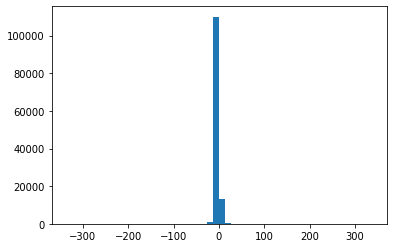

In [85]:
plt.hist(np.diff(positions[:, 1]), 50)


### Plot sessions stats

In [72]:
import matplotlib.pyplot as plt

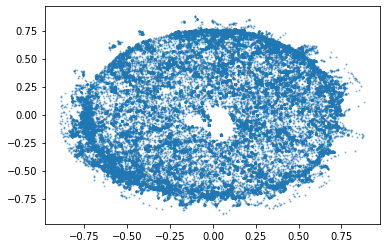

In [80]:
plt.scatter(pos_at_freq[:, 1], pos_at_freq[:, 2], s=1, alpha=0.1)

In [37]:
with h5py.File(h5name, 'r') as f:
    ds = np.array(f['raw']['positions'])
    hd = f['raw']['positions'].attrs['headers']

In [38]:
ds, hd

(array([[1.62762993e+09, 7.61000000e+02, 5.26000000e+02],
        [1.62762993e+09, 7.62000000e+02, 5.25000000e+02],
        [1.62762993e+09, 7.62000000e+02, 5.25000000e+02],
        ...,
        [1.62763243e+09, 3.46000000e+02, 5.01000000e+02],
        [1.62763243e+09, 3.45000000e+02, 5.11000000e+02],
        [1.62763243e+09, 3.45000000e+02, 5.11000000e+02]]),
 'time,x,y\n')

In [6]:
header

'time,x,y\n'